# 1. Initial data stats: category trends

In [1]:
import numpy as np
import pandas as pd

import re
from helpers import plot_bar

In [2]:
df = pd.read_csv('sample_data.csv')

In [3]:
df.head()

,url,html,cat
0,adworthy.com/,contact us (215) 321-3862\n\n#\n\n * optimiza...,hvpm
1,bbidisplays.com/,navigationhomesite mapproductsbbi displays ibb...,hvpm
2,blog.barterquest.com/,* about barterquest\n * press\n * system sta...,hvpm
3,catclamp.com/,about us | how it works | accessories | faq's ...,hvpm
4,chknutrition.com/,cart:\n\n0 items $0.00\n\nno products in the ...,hvpm


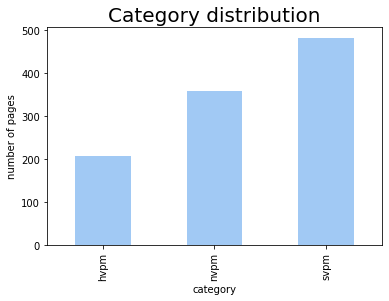

In [4]:
plot_bar(df.groupby('cat').url.count(), xlabel='category', ylabel='number of pages', title='Category distribution')

In [5]:
df.loc[:, 'url_patent'] = df.url.apply(lambda s: 'patent' in s)

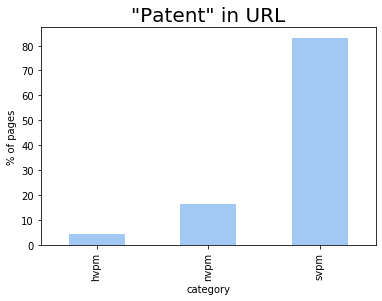

In [6]:
tmp = df.groupby('cat').url_patent.sum() / df.groupby('cat').url.count() * 100
plot_bar(data=tmp, xlabel='category', ylabel='% of pages', title='\"Patent\" in URL')

We suppose that since the percentage of pages with the word "patent" in the URL is very high for SVPM pages, this could be a good feature to take into consideration when selecting predictive features.

In [7]:
df.loc[:, 'html_n_patent'] = df.html.apply(lambda s: s.count('patent'))

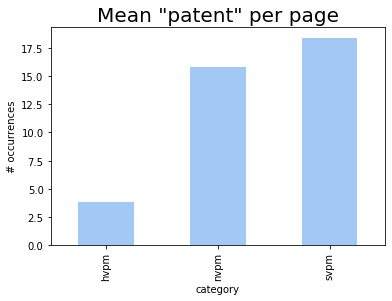

In [8]:
tmp = df.groupby('cat').html_n_patent.mean()
plot_bar(data=tmp, xlabel='category', ylabel='# occurrences', title='Mean \"patent\" per page')

We can see that the mean number of times the term "patent" occurs in NVPM pages is quite high, almost as high for SVPM pages. This could be due to blogs discussing IP and other topics that refer to patents many times. We study the median to see if this brings many outliers.

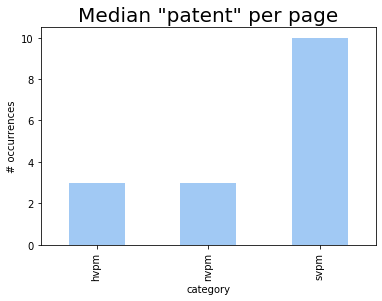

In [9]:
tmp = df.groupby('cat').html_n_patent.median()
plot_bar(data=tmp, xlabel='category', ylabel='# occurrences', title='Median \"patent\" per page')

We can clearly see that using the mean was indeed causing a bias towards the outliers, as mean is not a very robust metric. We see that based on the median, SVPM pages tend to have the word "patent" in the page more than the HPVM/NVPM pages do. More specifically, on median SVPM pages have 10 occurrences of the word "patent" in the simplified HTML, whereas HVPM and NVPM pages only have three occurrence of "patent" in the simplified HTML.

It would still be interesting to consider the performance of a classifier that considers mean metric, compared to one that considers the median metric.

In [10]:
us_codes = ['35 u.s.c. § 287', '35 usc § 287', '35 u.s.c. §287', '35 usc §287', '35 u.s.c.', 'section 287']

df['n_us_code'] = 0

for idx, row in df.iterrows():
    n = sum([row.html.lower().count(code) for code in us_codes])
    df.loc[idx, 'n_us_code'] = n

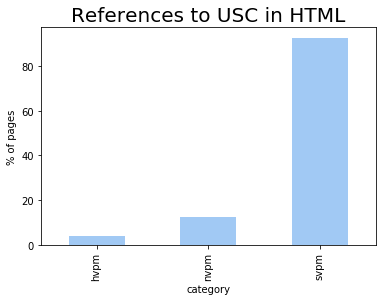

In [11]:
plot_bar(data=df.groupby('cat').n_us_code.sum() / df.groupby('cat').html.count() * 100,
         xlabel='category',
         ylabel='% of pages',
         title='References to USC in HTML')

We see that over 90% of SVPM pages refer to 35 U.S.C. § 287 in some way, whereas NVPM and HVPM are much less likely to do so, with fewer than 15% of pages referring to the code. This would most likely be a good feature to add to the classifier when performing feature selection.

In [12]:
df.loc[:, 'url_product'] = df.url.apply(lambda s: 'product' in s)

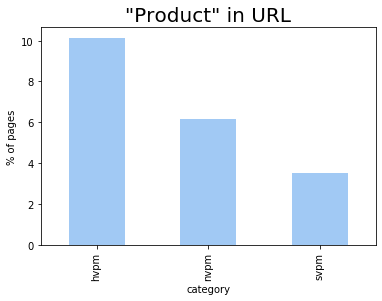

In [13]:
tmp = df.groupby('cat').url_product.sum() / df.groupby('cat').url.count() * 100
plot_bar(data=tmp, xlabel='category', ylabel='% of pages', title='\"Product\" in URL')

Considering pages based on whether the word "product" is in the URL seems like it would not be very helpful, as few pages have a tendency to have "product" in the URL, regardless of the category. Nonetheless, it is much more likely amongst HVPM web pages.

In [14]:
product_terms = ['product manual', 'user guide', 'user manual', 'product specifications',
                 'product details', 'product description']

df['n_product'] = 0

for idx, row in df.iterrows():
    n = sum([row.html.lower().count(s) for s in product_terms])
    df.loc[idx, 'n_product'] = n

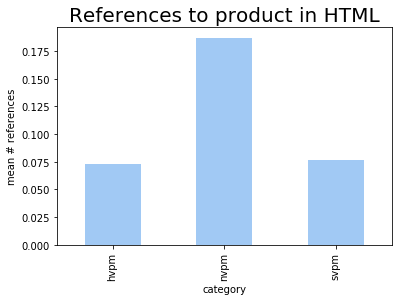

In [15]:
plot_bar(data=df.groupby('cat').n_product.mean(),
         xlabel='category',
         ylabel='mean # references',
         title='References to product in HTML')

Although the mean number of references to terms such as "product manual" or "user guide" in the HTML of NVPM pages is more than twice that of the other categories, it stays quite low. Thus, it is likely better not to focus on such references when performing feature selection.

In [16]:
df['len_url'] = df['url'].apply(lambda x: len(x))

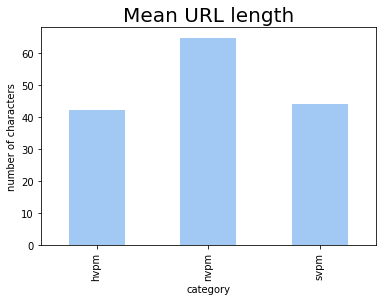

In [17]:
plot_bar(data=df.groupby('cat').len_url.mean(),
         xlabel='category',
         ylabel='number of characters',
         title='Mean URL length')

We observe that NVPM URLs tend to be longer in the number of characters than SVPM and HVPM, on average.

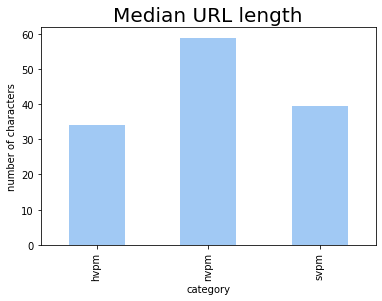

In [18]:
plot_bar(data=df.groupby('cat').len_url.median(),
         xlabel='category',
         ylabel='number of characters',
         title='Median URL length')

We observe the same trend for the median URL length, so it would possibly be an interesting metric to consider when performing feature selection: VPM pages tend to have shorter URLs.

In [19]:
df.loc[:, 'url_news'] = df.url.apply(lambda s: any(term in s for term in ['news', 'blog', 'article']))

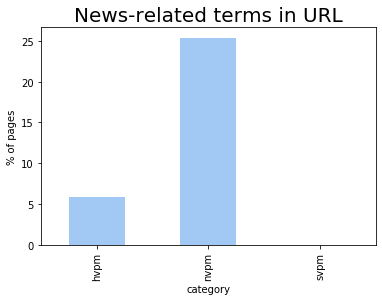

In [20]:
tmp = df.groupby('cat').url_news.sum() / df.groupby('cat').url.count() * 100
plot_bar(data=tmp, xlabel='category', ylabel='% of pages', title='News-related terms in URL')

We observe the significant percentage of NVPM pages that contain the terms "news", "blog" or "article" in the URL. This is of course biased towards the data collected: we mainly consider news, document and other as the subcategories of NVPM pages. Nonetheless, amongst web-scraped data, a significant number of collected pages are pages and blogs (as observed from previous SCITAS web-scraped data), so this could be a valuable feature to consider in the classifier. It would also be potentially valuable to remove pages when scraping based on the presence of these words in the URL: very few HVPM pages would be removed: not too many false positives, and most of all, almost no SVPM pages would be removed, based on the trends in the current dataset.

In [21]:
df.loc[:, 'n_patent_strings'] = df.html.apply(lambda s: len(re.findall(r'\b(\d{1}[,\s]\d{3}[,\s]\d{3}|US\d{7})\b', s)))

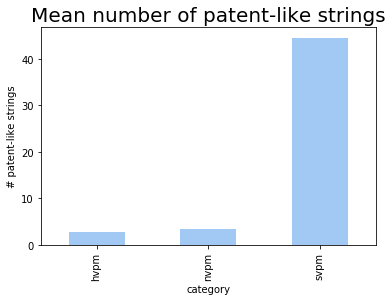

In [22]:
plot_bar(data=df.groupby('cat').n_patent_strings.mean(),
         xlabel='category',
         ylabel='# patent-like strings',
         title='Mean number of patent-like strings')

In [23]:
df.groupby('cat').n_patent_strings.max()

cat
hvpm      39
nvpm     188
svpm    1636
Name: n_patent_strings, dtype: int64

We consider US patent-like strings of the form `X,XXX,XXX` or `X XXX XXX`. As expected, the mean number of patent-like strings per page is very high for SVPM pages, compared to HVPM and NVPM. However, as we know, mean is not very robust and it is likely that there are many outliers in SVPM pages that contain over 100 such references. Indeed, the maximum number of such strings identified is 1636 in an SVPM page. We study the median number of patent-like strings per page instead.

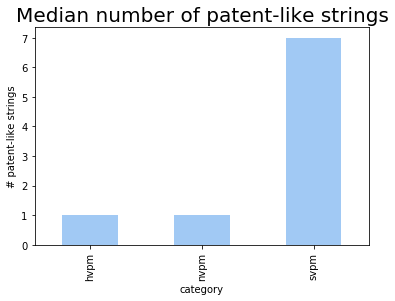

In [24]:
plot_bar(data=df.groupby('cat').n_patent_strings.median(),
         xlabel='category',
         ylabel='# patent-like strings',
         title='Median number of patent-like strings')

Again, as expected, the number of patent-like strings is significantly higher in the SVPM pages than in the HVPM and NVPM pages. More specifically, on median, the number of such strings is 7 per page, whereas it is only one for HVPM and NVPM pages. This would thus be a good metric to consider in feature selection.

In [25]:
date_pattern_url = r'(\d{1,2}[./-]\d{1,2}[./-]\d{4}|\d{4}[./-]\d{1,2}[./-]\d{1,2}|20\d{2}[0-3]\d{1}[0-3]\d{1}|[0-3]\d{1}[0-3]\d{1}20\d{2})'

In [26]:
df.loc[:, 'url_date'] = df.url.apply(lambda s: len(re.findall(date_pattern_url, s)) > 0)

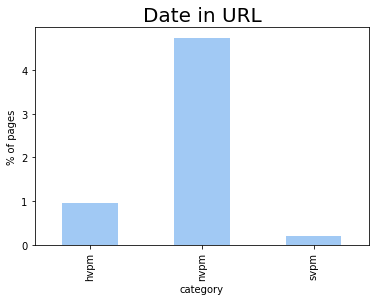

In [27]:
plot_bar(data=df.groupby('cat').url_date.sum() / df.groupby('cat').url.count() * 100,
         xlabel='category',
         ylabel='% of pages',
         title='Date in URL')

While not many NVPM pages have date-like strings in their URLs, the relative percentage compared to HVPM and SVPM pages makes it a possibly interesting metric to consider.

In [28]:
date_pattern = r'(\d{1,2}[./-]\d{1,2}[./-]\d{4}|\d{4}[./-]\d{1,2}[./-]\d{1,2})'

In [29]:
df.loc[:, 'n_dates'] = df.html.apply(lambda s: len(re.findall(date_pattern, s)))

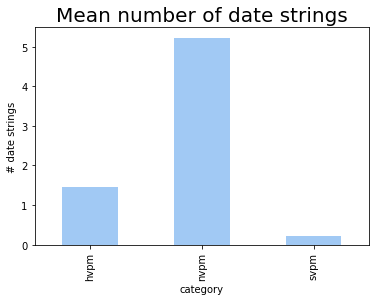

In [30]:
plot_bar(data=df.groupby('cat').n_dates.mean(),
         xlabel='category',
         ylabel='# date strings',
         title='Mean number of date strings')

We can see that the mean number of date strings in an HTML page is quite high for NVPM pages, low for HVPM pages, and negligible for SVPM pages. This should be considered in the feature selection process, given the difference between categories. This is again most likely due to the presence of news and blog websites in the NVPM pages.

In [31]:
df['contains_date'] = df['n_dates'] > 0

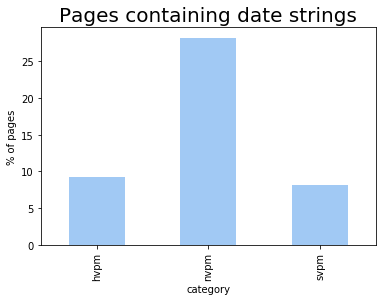

In [32]:
plot_bar(data=df.groupby('cat').contains_date.sum() / df.groupby('cat').url.count() * 100,
         xlabel='category',
         ylabel='% of pages',
         title='Pages containing date strings')

We can see that almost 30% of NVPM pages contain date-like strings, whereas fewer than 10% of HVPM and SVPM pages contain date-like strings. This could be a good feature to consider in the feature selection process.

In [33]:
df.to_csv('sample_data.csv', encoding='utf-8', header=True, index=False)